# BreaQ QML Track: Hybrid Quantum-Classical Neural Networks for RetinaMNIST

This hackathon focuses on developing hybrid quantum–classical neural networks for the RetinaMNIST dataset. *The emphasis is on designing interesting hybrid models and on finding meaningful metrics to investigate the advantage of using quantum resources.* You are encouraged to experiment with architecture design, analyze performance, and propose meaningful experiments or metrics that quantify the impact of quantum resources within the model.

To support this process, the notebook presents a complete, ready-to-run pipeline based on PyTorch and PennyLane. The example demonstrates data handling, model construction, training, and evaluation using a hybrid neural network workflow. 

#### Feel free to reuse or adapt the provided implementation in any form. The only mandatory requirements for submissions are the use of PennyLane and PyTorch.

In [1]:
import json
import numpy as np
from PIL import Image
from medmnist import RetinaMNIST
import pennylane as qml
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
from typing import Tuple


## The Dataset: RetinaMNIST

RetinaMNIST is a compact medical imaging dataset composed of retinal fundus photographs labeled on a 5-point diabetic retinopathy severity scale. Although the task is inherently ordinal regression, it is often treated as a standard multi-class classification problem. Its limited size and low resolution make it well suited for rapid experimentation, benchmarking lightweight models, and evaluating hybrid quantum–classical approaches under realistic small-data constraints.

In the following, you are provided with a class to help you load and preprocess the RetinaMNIST dataset. The class handles downloading the data, applying necessary transformations, and preparing it for training and evaluation. Some of the methods already implemented:
 - `__init__`: Loads train, validation, and test splits into memory and formats images and labels.
 - `select_classes`: Filters all splits to keep only a specified set of class IDs.
 - `select_train_percentage`: Retains only a chosen fraction of the training set, with optional shuffling.
 - `normalize`: Applies either min–max scaling or standardization independently to each split.
 - `to_grayscale`: Converts all images to single-channel grayscale format.
 - `resize`: Resizes images in every split to a specified spatial resolution.

Bellow the `DataHandler` implementations there are also some usage examples.

In [2]:
class DataHandler:
    def __init__(self, download=True, as_rgb=True):
        """
        Loads train/val/test splits simultaneously.
        """
        self.datasets = {}
        self.images = {}
        self.labels = {}

        for split in ["train", "val", "test"]:
            ds = RetinaMNIST(split=split, download=download)
            imgs = ds.imgs  # (N, 28, 28)
            labels = ds.labels.squeeze()

            if imgs.ndim == 3:
                if as_rgb:
                    imgs = np.stack([imgs]*3, axis=-1)   # (N, H, W, 3)
                else:
                    imgs = imgs[..., None]               # (N, H, W, 1)

            self.images[split] = imgs.astype(np.uint8)
            self.labels[split] = labels.astype(int)

        self.active_classes = {
            split: np.unique(self.labels[split]) for split in ["train", "val", "test"]
        }

    def select_classes(self, classes):
        """
        Keep only specific class IDs across train, val, test.
        """
        for split in ["train", "val", "test"]:
            cls_set = set(classes)
            mask = np.array([lbl in cls_set for lbl in self.labels[split]])
            self.images[split] = self.images[split][mask]
            self.labels[split] = self.labels[split][mask]
            self.active_classes[split] = np.array(sorted(classes))

    def select_train_percentage(self, pct, shuffle=True, seed=None):
        """
        Keep only a percentage of the training data, preserving class proportions.
        pct: float in (0,1]
        """
        assert 0 < pct <= 1
        N = len(self.labels["train"])
        n_keep = int(N * pct)

        rng = np.random.default_rng(seed)

        classes, counts = np.unique(self.labels["train"], return_counts=True)
        # desired (float) and initial integer allocation per class
        desired = counts * pct
        per_class = np.floor(desired).astype(int)

        # adjust to match total n_keep by distributing the remaining slots
        remainder = n_keep - per_class.sum()
        if remainder > 0:
            fracs = desired - per_class
            order = np.argsort(-fracs)  # largest fractional parts first
            for i in order[:remainder]:
                per_class[i] += 1
        elif remainder < 0:
            rem = -remainder
            fracs = desired - per_class
            order = np.argsort(fracs)  # smallest fractional parts first
            for i in order:
                if per_class[i] > 0:
                    per_class[i] -= 1
                    rem -= 1
                    if rem == 0:
                        break

        # gather indices per class
        keep_idx_list = []
        for cls, k in zip(classes, per_class):
            cls_idx = np.where(self.labels["train"] == cls)[0].copy()
            if shuffle:
                rng.shuffle(cls_idx)
            if k > 0:
                keep_idx_list.append(cls_idx[:k])

        if keep_idx_list:
            keep_idx = np.concatenate(keep_idx_list)
        else:
            keep_idx = np.array([], dtype=int)

        if shuffle and keep_idx.size:
            rng.shuffle(keep_idx)

        self.images["train"] = self.images["train"][keep_idx]
        self.labels["train"] = self.labels["train"][keep_idx]
        self.active_classes["train"] = np.unique(self.labels["train"])

    def normalize(self, method="minmax"):
        """
        Normalize each split independently.
        """
        for split in ["train", "val", "test"]:
            imgs = self.images[split].astype(np.float32)

            if method == "minmax":
                min_val = imgs.min(axis=(0,1,2), keepdims=True)
                max_val = imgs.max(axis=(0,1,2), keepdims=True)
                imgs = (imgs - min_val) / (max_val - min_val + 1e-7)

            elif method == "standard":
                mean = imgs.mean(axis=(0,1,2), keepdims=True)
                std = imgs.std(axis=(0,1,2), keepdims=True) + 1e-7
                imgs = (imgs - mean) / std

            else:
                raise ValueError("Unknown normalization method.")

            self.images[split] = imgs

    def to_grayscale(self):
        """
        Convert images in all splits to grayscale.
        """
        for split in ["train", "val", "test"]:
            gray_list = []
            for img in self.images[split]:
                pil = Image.fromarray(img).convert("L")
                gray_list.append(np.array(pil))
            gray_arr = np.stack(gray_list, axis=0)
            self.images[split] = gray_arr[..., None]

    def resize(self, size):
        """
        Resize images in all splits to (width, height).
        """
        for split in ["train", "val", "test"]:
            out = []
            for img in self.images[split]:
                if img.shape[-1] == 1:
                    pil = Image.fromarray(img.squeeze(), mode="L")
                else:
                    pil = Image.fromarray(img)

                pil = pil.resize(size, Image.BILINEAR)
                arr = np.array(pil)

                if arr.ndim == 2:
                    arr = arr[..., None]

                out.append(arr)
            self.images[split] = np.stack(out, axis=0)


# ------------- Dataset wrapper -------------
def build_dataloaders_fast(dh, batch_size=128, device='cuda'):
    """
    Pre-convert all images to torch.Tensor once.
    """
    loaders = {}
    for split in ["train", "val", "test"]:
        imgs = torch.from_numpy(dh.images[split]).float()  # (N,H,W,C)
        # HWC -> CHW
        imgs = imgs.permute(0,3,1,2)
        if imgs.max() > 1.0:
            imgs /= 255.0
        labels = torch.from_numpy(dh.labels[split]).long()
        dataset = TensorDataset(imgs, labels)
        shuffle = (split == "train")
        loaders[split] = DataLoader(dataset, batch_size=batch_size,
                                    shuffle=shuffle,
                                    num_workers=4,  # increase if your CPU has cores
                                    pin_memory=True if device=='cuda' else False)
    return loaders


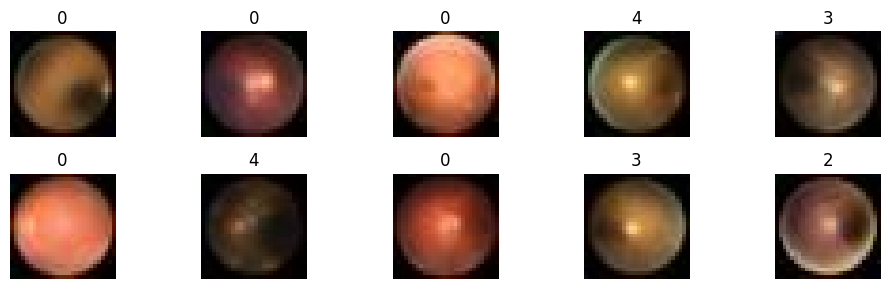

In [24]:
# Raw
import matplotlib.pyplot as plt

dh = DataHandler()

imgs = dh.images["train"][:10]
labels = dh.labels["train"][:10]

plt.figure(figsize=(10, 3))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(imgs[i])
    plt.axis("off")
    plt.title(labels[i])
plt.tight_layout()
plt.show()


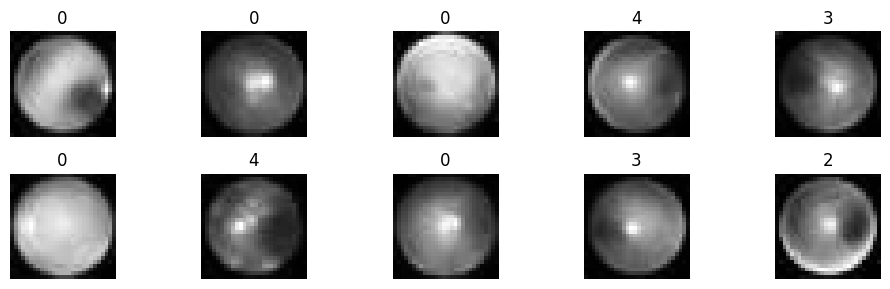

In [25]:
# Grayscale
dh = DataHandler()
dh.to_grayscale()

imgs = dh.images["train"][:10].squeeze(-1)
labels = dh.labels["train"][:10]

plt.figure(figsize=(10, 3))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(imgs[i], cmap="gray")
    plt.axis("off")
    plt.title(labels[i])
plt.tight_layout()
plt.show()

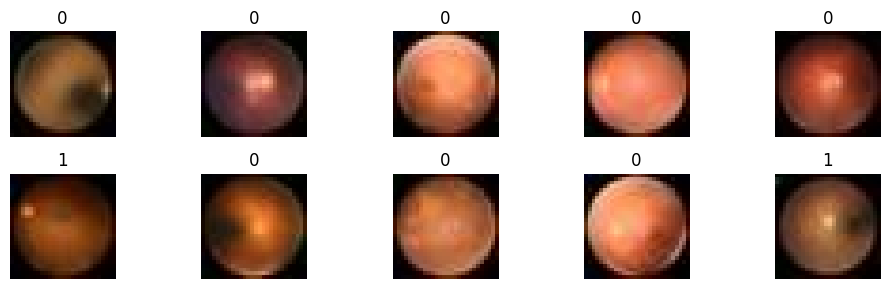

In [26]:
# Classes 0 and 1
dh = DataHandler()
dh.select_classes([0, 1])

imgs = dh.images["train"][:10]
labels = dh.labels["train"][:10]

plt.figure(figsize=(10, 3))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(imgs[i])
    plt.axis("off")
    plt.title(labels[i])
plt.tight_layout()
plt.show()

In [27]:
# keep 20% of the training set
dh = DataHandler()

print("Before:", len(dh.labels["train"]))

dh.select_train_percentage(0.2, seed=0)

print("After:", len(dh.labels["train"]))

Before: 1080
After: 216


## The model: building HQNNs with PennyLane and PyTorch

The model combines classical deep learning components from PyTorch with a trainable quantum circuit defined using PennyLane. The outer structure is a subclass of `torch.nn.Module`, which is the standard building block for neural networks in PyTorch. Layers are defined in the constructor and organized into `nn.Sequential` blocks, allowing multiple operations such as convolutions, activations, pooling, and linear layers to be stacked into a forward pipeline.

The quantum part is defined as a function decorated with `@qml.qnode`, which tells PennyLane to turn it into a differentiable quantum computation. The shape of the trainable quantum parameters is declared through `weight_shapes`, which ensures compatibility with downstream optimization. The quantum circuit is wrapped with `qml.qnn.TorchLayer`, allowing it to behave like a standard neural network layer inside PyTorch. This means it receives and outputs tensors just like a classical layer and its parameters are tracked by PyTorch’s optimizer. Both quantum and classical weights participate in the same training loop.

The `forward` method defines the flow of data: images pass first through convolutional feature extraction, then through the classifier, and finally through the quantum layer. Gradients propagate automatically across the entire pipeline. PennyLane provides differentiable quantum simulations, while PyTorch’s autograd engine ensures that parameter updates seamlessly include both the neural network weights and the quantum circuit parameters in a single backward pass.

In [ ]:
import torch
import torch.nn as nn
import pennylane as qml
from torchvision import models  
import numpy as np

#Model Hibrid Resnet
def build_model(num_classes: int, in_channels: int = 3):
    n_qubits = 4
    n_layers = 2
    dev = qml.device("default.qubit", wires=n_qubits)
    weight_shapes = {"weights": (n_layers, n_qubits, 3)}

    @qml.qnode(dev)
    def qnode(inputs, weights):
        for i in range(n_layers):
            qml.AngleEmbedding(inputs, wires=range(n_qubits), rotation='Y')
            qml.StronglyEntanglingLayers(weights[i].unsqueeze(0), wires=range(n_qubits))
        return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

    class HybridResNet(nn.Module):
        def __init__(self):
            super().__init__()
            self.base_model = models.resnet18(pretrained=True)
            
            # Freeze params (Transfer Learning)
            for param in self.base_model.parameters():
                param.requires_grad = False
            
            #Quantum layer
            self.base_model.fc = nn.Sequential(
                nn.Linear(512, n_qubits), # Reducem la 4
                nn.Tanh(),                # Normalizăm (-1, 1)
                qml.qnn.TorchLayer(qnode, weight_shapes)
            )
            
            # Final classification
            self.final_classifier = nn.Linear(n_qubits, num_classes)

        def forward(self, x):
            x = self.base_model(x)
            x = self.final_classifier(x)
            return x

    return HybridResNet()



For prototyping it is useful to visualize the quantum circuits. The following cell shows how to plot a quantum circuit using PennyLane's built-in drawing capabilities. The argument `level=None` ensures that all operations are displayed without collapsing them into higher-level gates.

c:\Users\Tavi\vs_code_projects\roqteam-qml\.venv\Lib\site-packages\pennylane\workflow\construct_batch.py:418: PennyLaneDeprecationWarning: Using `level=None` is deprecated and will be removed in a future release. Please use `level='device'` to include all transforms.
  _validate_level(level)


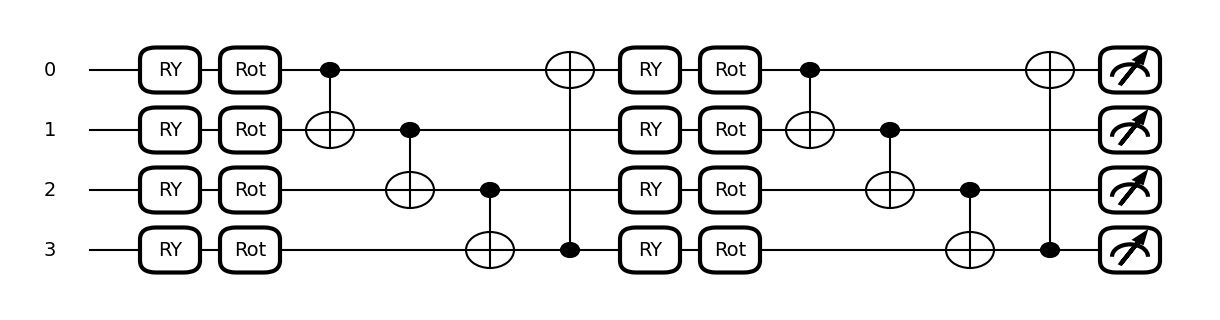

In [3]:
n_qubits = 4
n_layers = 2
dev = qml.device("default.qubit", wires=n_qubits)
weight_shapes = {"weights": (n_layers, n_qubits, 3)}

@qml.qnode(dev)
def qnode(inputs, weights):
    for layer_idx in range(n_layers):
        qml.AngleEmbedding(inputs, wires=range(n_qubits), rotation='Y')
        qml.StronglyEntanglingLayers(weights[layer_idx][None, ...], wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

inputs_sample = np.random.rand(n_qubits)
weights_sample = np.random.rand(n_layers, n_qubits, 3)
fig, ax = qml.draw_mpl(qnode, level=None)(inputs_sample, weights_sample)
fig.set_size_inches(12, 3)
plt.show()

## Training and Evaluation

The training loop follows standard PyTorch conventions. The `train_epoch` function sets the model to training mode, iterates over a data loader, performs forward and backward passes, and updates parameters using the provided optimizer. The loss is computed with a user-defined criterion, and predictions are stored for later metric calculation.

The evaluation function performs the same forward computation in evaluation mode but under `torch.no_grad()`, ensuring that no gradients are tracked and computation is more efficient. No parameter updates occur during evaluation.

In [5]:

# ------------- Training utilities -------------
def train_epoch(model, loader, optimizer, device, criterion):
    model.train()
    running_loss = 0.0
    preds_all = []
    labels_all = []

    for imgs, labels in loader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        logits = model(imgs)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        preds_all.append(logits.detach().cpu().numpy())
        labels_all.append(labels.detach().cpu().numpy())

    epoch_loss = running_loss / len(loader.dataset)
    preds_all = np.concatenate(preds_all, axis=0)
    labels_all = np.concatenate(labels_all, axis=0)
    # Probabilities for AUC: softmax
    probs = torch.from_numpy(preds_all).softmax(dim=1).numpy() if preds_all.ndim==2 else preds_all
    pred_labels = probs.argmax(axis=1)
    acc = accuracy_score(labels_all, pred_labels)

    # AUC: handle binary vs multiclass
    try:
        if probs.shape[1] == 1:
            auc = roc_auc_score(labels_all, probs.ravel())
        else:
            auc = roc_auc_score(labels_all, probs, multi_class='ovr')
    except Exception:
        auc = float('nan')

    return epoch_loss, acc, auc

def evaluate(model, loader, device, criterion):
    model.eval()
    running_loss = 0.0
    preds_all = []
    labels_all = []

    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)
            labels = labels.to(device)
            logits = model(imgs)
            loss = criterion(logits, labels)

            running_loss += loss.item() * imgs.size(0)
            preds_all.append(logits.cpu().numpy())
            labels_all.append(labels.cpu().numpy())

    epoch_loss = running_loss / len(loader.dataset)
    preds_all = np.concatenate(preds_all, axis=0)
    labels_all = np.concatenate(labels_all, axis=0)
    probs = torch.from_numpy(preds_all).softmax(dim=1).numpy() if preds_all.ndim==2 else preds_all
    pred_labels = probs.argmax(axis=1)
    acc = accuracy_score(labels_all, pred_labels)
    try:
        if probs.shape[1] == 1:
            auc = roc_auc_score(labels_all, probs.ravel())
        else:
            auc = roc_auc_score(labels_all, probs, multi_class='ovr')
    except Exception:
        auc = float('nan')

    return epoch_loss, acc, auc


## Experiments

The `run_training` function automates the entire workflow of training and evaluating a model. It prepares data loaders, builds the hybrid network, and runs multiple training epochs using the provided optimizer and loss function. After each epoch, validation metrics are computed, and once finished, the model is also tested on the held-out test set. All results, including loss, accuracy, and AUC, are recorded and visualized in plots, providing a clear overview of model performance across the training process.

In [6]:

def run_training(dh: DataHandler,
                 num_epochs: int = 30,
                 batch_size: int = 64,
                 lr: float = 1e-4,
                 resize: Tuple[int,int] = (28,28),
                 grayscale: bool = True,
                 train_pct: float = 1.0,
                 device: str = None):
    
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    print("Started training on ", device, "...")

    if train_pct < 1.0:
        dh.select_train_percentage(train_pct, seed=42)

    loaders = build_dataloaders_fast(dh, batch_size=batch_size, device=device)
    
    unique_labels = np.unique(dh.labels["train"])
    num_classes = len(unique_labels)
    in_ch = dh.images["train"].shape[-1]

    model = build_model(num_classes=num_classes, in_channels=in_ch).to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=3
    )

    # Class Weights
    print("Calculating class weights...")
    all_labels = dh.labels['train'].flatten()
    class_counts = np.bincount(all_labels)
    class_counts = np.where(class_counts == 0, 1, class_counts)
    total_samples = len(all_labels)
    weights = total_samples / (len(class_counts) * class_counts)
    class_weights = torch.tensor(weights, dtype=torch.float).to(device)
    
    criterion = nn.CrossEntropyLoss(weight=class_weights)

    history = {"train_loss": [], "train_acc": [], "train_auc": [],
               "val_loss": [], "val_acc": [], "val_auc": []}
    
    print("Model built. Starting loop...")

    for epoch in range(1, num_epochs+1):
        tr_loss, tr_acc, tr_auc = train_epoch(model, loaders["train"], optimizer, device, criterion)
        val_loss, val_acc, val_auc = evaluate(model, loaders["val"], device, criterion)
        
        scheduler.step(val_loss)

        
        print(f"Epoch {epoch:02d} | Train loss {tr_loss:.4f} acc {tr_acc:.4f} auc {tr_auc:.4f}")
        print(f"          | Val   loss {val_loss:.4f} acc {val_acc:.4f} auc {val_auc:.4f}")

        history["train_loss"].append(tr_loss)
        history["train_acc"].append(tr_acc)
        history["train_auc"].append(tr_auc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
        history["val_auc"].append(val_auc)

    test_loss, test_acc, test_auc = evaluate(model, loaders["test"], device, criterion)
    print(f"\nTest result -> Loss: {test_loss:.4f} | Acc: {test_acc:.4f} | AUC: {test_auc:.4f}")

    epochs_range = np.arange(1, num_epochs+1)
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.plot(epochs_range, history["train_loss"], label="train")
    plt.plot(epochs_range, history["val_loss"], label="val")
    plt.title("Loss"); plt.legend()
    plt.subplot(1,3,2)
    plt.plot(epochs_range, history["train_acc"], label="train")
    plt.plot(epochs_range, history["val_acc"], label="val")
    plt.title("Accuracy"); plt.legend()
    plt.subplot(1,3,3)
    plt.plot(epochs_range, history["train_auc"], label="train")
    plt.plot(epochs_range, history["val_auc"], label="val")
    plt.title("AUC"); plt.legend()
    plt.tight_layout()
    plt.show()

    return model, history, (test_loss, test_acc, test_auc)

Loading RGB Data for ResNet...
Starting Hybrid ResNet Transfer Learning...
Started training on  cpu ...


c:\Users\Tavi\vs_code_projects\roqteam-qml\roqteam-qml\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Tavi\vs_code_projects\roqteam-qml\roqteam-qml\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Calculating class weights...
Model built. Starting loop...
Epoch 01 | Train loss 1.6304 acc 0.1611 auc 0.5194
          | Val   loss 1.6018 acc 0.3167 auc 0.6474
Epoch 01 | Train loss 1.6304 acc 0.1611 auc 0.5194
          | Val   loss 1.6018 acc 0.3167 auc 0.6474
Epoch 02 | Train loss 1.6040 acc 0.3167 auc 0.6204
          | Val   loss 1.5800 acc 0.3250 auc 0.6701
Epoch 02 | Train loss 1.6040 acc 0.3167 auc 0.6204
          | Val   loss 1.5800 acc 0.3250 auc 0.6701
Epoch 03 | Train loss 1.5797 acc 0.3296 auc 0.6550
          | Val   loss 1.5636 acc 0.3250 auc 0.6866
Epoch 03 | Train loss 1.5797 acc 0.3296 auc 0.6550
          | Val   loss 1.5636 acc 0.3250 auc 0.6866
Epoch 04 | Train loss 1.5631 acc 0.3463 auc 0.6781
          | Val   loss 1.5460 acc 0.3333 auc 0.6897
Epoch 04 | Train loss 1.5631 acc 0.3463 auc 0.6781
          | Val   loss 1.5460 acc 0.3333 auc 0.6897
Epoch 05 | Train loss 1.5515 acc 0.3537 auc 0.6827
          | Val   loss 1.5368 acc 0.3583 auc 0.6964
Epoch 05 | Tra

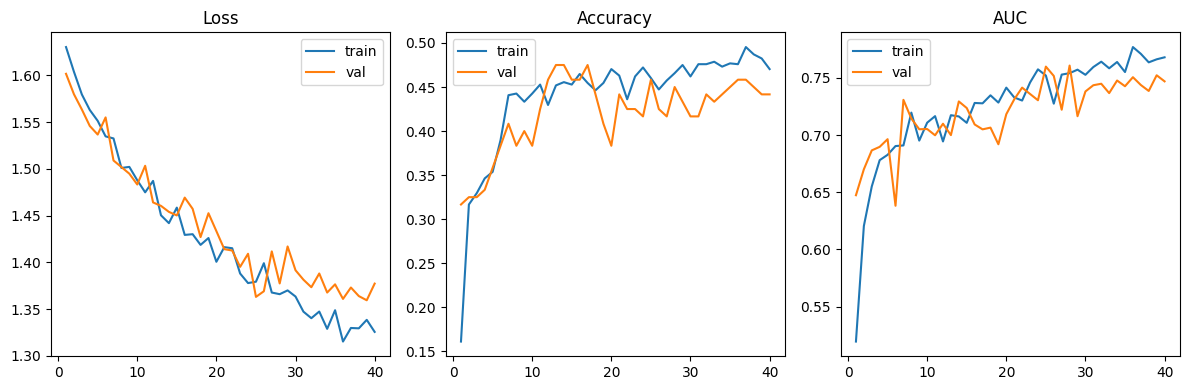

Final ResNet Metrics: (1.484964804649353, 0.4, 0.6726419789513052)


In [ ]:
#Training

print("Loading RGB Data for ResNet...")
dh = DataHandler(download=True, as_rgb=True) 
dh.normalize('minmax')

print("Starting Hybrid ResNet Transfer Learning...")


model, history, test_metrics = run_training(
    dh=dh,
    num_epochs=40,       
    batch_size=32, 
    lr=1e-3,             
    resize=(128, 128),   # Resize for ResNet
    grayscale=False,     
    train_pct=1.0        
)

print("Final ResNet Metrics:", test_metrics)

## NORMAL CNN TO COMPARE



In [ ]:


class ClassicalCNN(nn.Module):
    def __init__(self, in_ch, n_classes):
        super().__init__()
        
        # Keep same CNN arhitecture
        self.features = nn.Sequential(
            nn.Conv2d(in_ch, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(2),
            
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.AdaptiveAvgPool2d(1)
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            #But we use a normal final layer for output
            nn.Linear(32, n_classes) 
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [ ]:
def run_classical_training(dh, num_epochs=40, batch_size=32, lr=1e-4, device=None):
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Training CLASSICAL model on {device}...")
    
    # Dataloaders
    loaders = build_dataloaders_fast(dh, batch_size=batch_size, device=device)
    num_classes = len(np.unique(dh.labels["train"]))
    in_ch = dh.images["train"].shape[-1]
    
    model = ClassicalCNN(in_ch, num_classes).to(device)
    
    # Optimizer and Scheduler 
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=3
    )
    
    # weights
    all_labels = dh.labels['train'].flatten()
    class_counts = np.bincount(all_labels)
    class_counts = np.where(class_counts == 0, 1, class_counts)
    weights = len(all_labels) / (len(class_counts) * class_counts)
    class_weights = torch.tensor(weights, dtype=torch.float).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    
    history = {"val_auc": [], "val_loss": [], "train_loss": []}
    
    for epoch in range(1, num_epochs+1):
        tr_loss, tr_acc, tr_auc = train_epoch(model, loaders["train"], optimizer, device, criterion)
        val_loss, val_acc, val_auc = evaluate(model, loaders["val"], device, criterion)
        scheduler.step(val_loss)
        
        print(f"Classic Epoch {epoch:02d} | Val AUC: {val_auc:.4f} | Val Loss: {val_loss:.4f}")
        
        history["val_auc"].append(val_auc)
        history["val_loss"].append(val_loss)
        history["train_loss"].append(tr_loss)
        
    return model, history

Training CLASSICAL model on cpu...
Classic Epoch 01 | Val AUC: 0.6298 | Val Loss: 1.6222
Classic Epoch 01 | Val AUC: 0.6298 | Val Loss: 1.6222
Classic Epoch 02 | Val AUC: 0.6431 | Val Loss: 1.5697
Classic Epoch 02 | Val AUC: 0.6431 | Val Loss: 1.5697
Classic Epoch 03 | Val AUC: 0.6524 | Val Loss: 1.5513
Classic Epoch 03 | Val AUC: 0.6524 | Val Loss: 1.5513
Classic Epoch 04 | Val AUC: 0.6677 | Val Loss: 1.5459
Classic Epoch 04 | Val AUC: 0.6677 | Val Loss: 1.5459
Classic Epoch 05 | Val AUC: 0.6660 | Val Loss: 1.5427
Classic Epoch 05 | Val AUC: 0.6660 | Val Loss: 1.5427
Classic Epoch 06 | Val AUC: 0.6743 | Val Loss: 1.5395
Classic Epoch 06 | Val AUC: 0.6743 | Val Loss: 1.5395
Classic Epoch 07 | Val AUC: 0.6755 | Val Loss: 1.5419
Classic Epoch 07 | Val AUC: 0.6755 | Val Loss: 1.5419
Classic Epoch 08 | Val AUC: 0.6811 | Val Loss: 1.5352
Classic Epoch 08 | Val AUC: 0.6811 | Val Loss: 1.5352
Classic Epoch 09 | Val AUC: 0.6876 | Val Loss: 1.5331
Classic Epoch 09 | Val AUC: 0.6876 | Val Loss: 

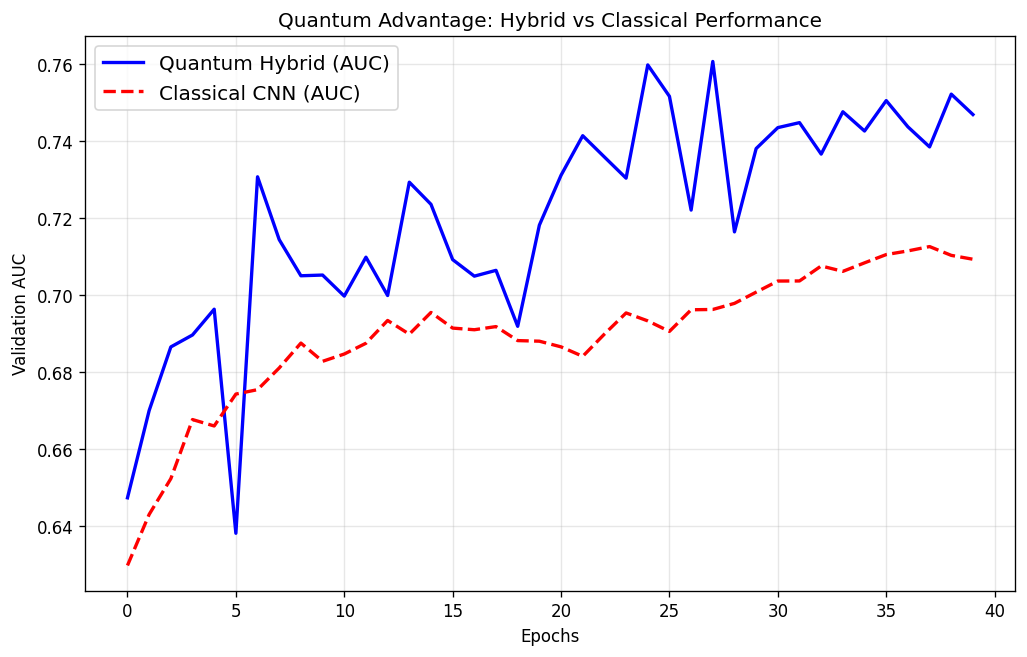

In [ ]:

dh = DataHandler(download=True, as_rgb=True)
dh.to_grayscale()
dh.normalize('minmax')

classic_model, classic_history = run_classical_training(
    dh, 
    num_epochs=40,   # Same parameters as the hybrid one
    batch_size=32,   
    lr=1e-4          
)


import json
quantum_history = history 

plt.figure(figsize=(10, 6))

# Quantum
plt.plot(quantum_history['val_auc'], label='Quantum Hybrid (AUC)', color='blue', linewidth=2)
# Classic
plt.plot(classic_history['val_auc'], label='Classical CNN (AUC)', color='red', linestyle='--', linewidth=2)

plt.title("Quantum Advantage: Hybrid vs Classical Performance")
plt.xlabel("Epochs")
plt.ylabel("Validation AUC")
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

.






## Model saver 


In [53]:
checkpoint_path = "Saved_models/Resnet.pth"
history_path = "Saved_models/Resnet.json"
torch.save(model.state_dict(), checkpoint_path)
with open(history_path, "w", encoding="utf-8") as fp:
    json.dump(history, fp)
print(f"Saved weights to {checkpoint_path} and history to {history_path}.")
metrics_dict = {
    "test_loss": test_metrics[0],
    "test_acc": test_metrics[1],
    "test_auc": test_metrics[2]
}

# Save to a separate JSON file
with open("Saved_models/Resnet_testset.json", "w") as f:
    json.dump(metrics_dict, f, indent=4)


In [ ]:
input = None
output = None